In [14]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
words = open('/content/drive/MyDrive/names.txt', 'r').read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [6]:
# create list of characters
chars = sorted(list(set(''.join(words))))

# create dictionary of characters
string_to_index = {s:i+1 for i,s in enumerate(chars)}
string_to_index['.'] = 0

# Invert string_to_index
index_to_string = {i:s for s,i in string_to_index.items()}
print(index_to_string)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [70]:
# Build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X = []
Y = []

for w in words:
  # print(w)
  context = [0] * block_size
  for char in w + '.':
    ix = string_to_index[char]

    X.append(context)
    Y.append(ix)
    # print(''.join(index_to_string[i] for i in context), '---->', index_to_string[ix])
    # crop and append
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [71]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [17]:
C = torch.randn((27, 2)) # 27 characters in a 2 dimensional space. the paper used 17000 words with 30 dimensions

In [21]:
X[1]
X[[1, 2, 3]]

tensor([[ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13]])

In [22]:
C[5]

tensor([-1.1180,  0.4248])

In [25]:
C[torch.tensor([1, 2, 3, 4, 5])]

tensor([[ 1.2529,  0.7294],
        [ 0.0118,  1.5869],
        [-0.9312, -0.0319],
        [ 1.1371, -0.4441],
        [-1.1180,  0.4248]])

In [23]:
C[X].shape

torch.Size([32, 3, 2])

In [18]:
emb = C[X] # We embed all integeres in X
emb.shape

torch.Size([32, 3, 2])

In [27]:
# hidden layer. 6 because we have 3 words (characters in our case)
# and 2 dimensions for each character. 3*2 = 6
# We are using 100 neurons as an example
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [28]:
# We need to transform emb, [32, 3, 2], to [32, 6] so we can do matmul
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [30]:
# Retrieves the embeddings of the first word (second and third)
emb[ :, 0, :].shape, emb[ :, 1, :].shape, emb[ :, 2, :].shape

(torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32, 2]))

In [32]:
torch.cat([emb[ :, 0, :], emb[ :, 1, :], emb[ :, 2, :]], ).shape

torch.Size([96, 2])

In [33]:
torch.cat([emb[ :, 0, :], emb[ :, 1, :], emb[ :, 2, :]], 1).shape

torch.Size([32, 6])

In [36]:
len(torch.unbind(emb, 1)) # Same as above

3

In [37]:
# This way we don't have to manually index and we can change block size independently
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([32, 6])

In [38]:
# AN EVEN MORE EFFICIENT WAY!!!
emb.view(32, 6).shape

torch.Size([32, 6])

In [40]:
# Verify that it's the correct tensor
emb.view(32, 6) == torch.cat(torch.unbind(emb, 1), 1)

tensor([[True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, True, True],
        [True, True, True, True, T

In [43]:
hidden_layer = emb.view(emb.shape[0], 6) @ W1 + b1 # 100 dimensional activations
# hidden_layer = emb.view(-1, 6) @ W1 + b1 # Same thing, just different
hidden_layer.shape

torch.Size([32, 100])

In [45]:
# With our activation function, tanh
hidden_layer = torch.tanh(emb.view(-1, 6) @ W1 + b1)
hidden_layer.shape

torch.Size([32, 100])

In [46]:
b1.shape

torch.Size([100])

In [47]:
# Broadcasting check
# 32, 100
#  1, 100

In [48]:
# Connect the 100 outputs from hidden layer. We are outputting probabilities of the next character
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [49]:
logits = hidden_layer @ W2 + b2
logits.shape

torch.Size([32, 27])

In [50]:
counts = logits.exp()

In [51]:
prob = counts / counts.sum(1, keepdim=True)

In [52]:
prob.shape

torch.Size([32, 27])

In [53]:
prob[0].sum()

tensor(1.0000)

In [54]:
# index into the rows of prob
# each row, we'd like to pluck out the probability of the character we want.
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(15.3864)

In [55]:
# ------------------ CLEAN UP ------------------

In [72]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [107]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [108]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [109]:
for p in parameters:
  p.requires_grad = True

In [104]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre # Creates learning rates between -0.001 and -1

In [113]:
lri = []
lossi = []
for i in range(10000):
  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]]
  hidden_layer = torch.tanh(emb.view(-1, 6) @ W1 + b1) # 32, 100
  logits = hidden_layer @ W2 + b2
  # This is cross entropy loss

  # counts = logits.exp()
  # prob = counts / counts.sum(1, keepdim=True)
  # loss = -prob[torch.arange(32), Y].log().mean()

  loss = F.cross_entropy(logits, Y[ix]) # More efficient
  # print(loss.item())

  # backwards pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  # In the beginning, it will be 0.001, in the end 1
  # lr = lrs[i]
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  # lossi.append(loss.item())
print(loss.item())

2.04988956451416


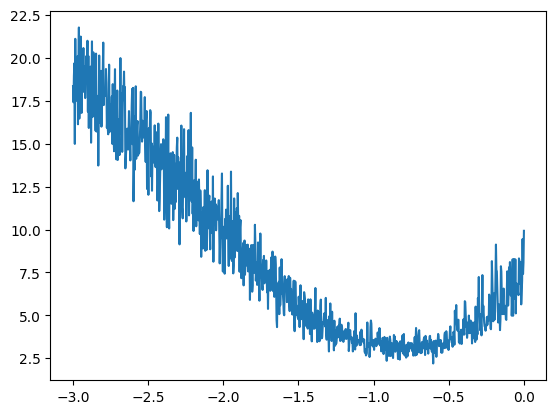

In [106]:
plt.plot(lri, lossi)

In [79]:
# Use batches
torch.randint(0, X.shape[0], (32,))

tensor([188085, 122934, 108061,  15451, 222813,  19800,  63357,   9173,  14577,
        151733, 201435,  72846,   7698, 210824, 105671,  56860,  72282,  31511,
        197029,  14313, 214553, 161121,  50558, 153205, 214808,  21694,  97976,
         90696,  73619,  20147, 213974, 214415])

In [114]:
# training split, validation split, test split
# 80, 10, 10
def build_dataset(words):
  block_size = 3
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for char in w + '.':
      ix = string_to_index[char]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [115]:
n1

25626

In [116]:
n2

28829

In [134]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [135]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [136]:
lri = []
lossi = []
stepi = []

In [143]:
for i in range(50000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]]
  hidden_layer = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = hidden_layer @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backwards pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  # lri.append(lre[i])
  lossi.append(loss.log10().item())
  stepi.append(i)

print(loss.item())

2.4182608127593994


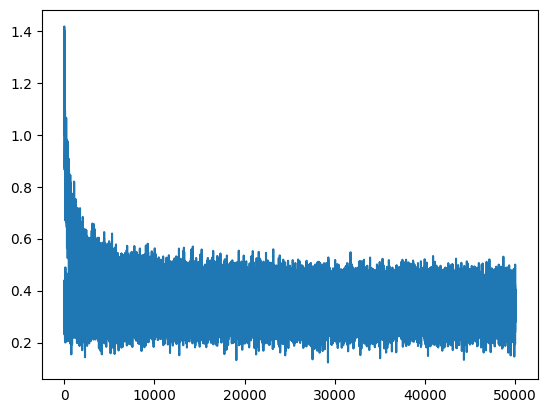

In [144]:
plt.plot(stepi, lossi)

In [145]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1591, grad_fn=<NllLossBackward0>)

In [146]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1905, grad_fn=<NllLossBackward0>)

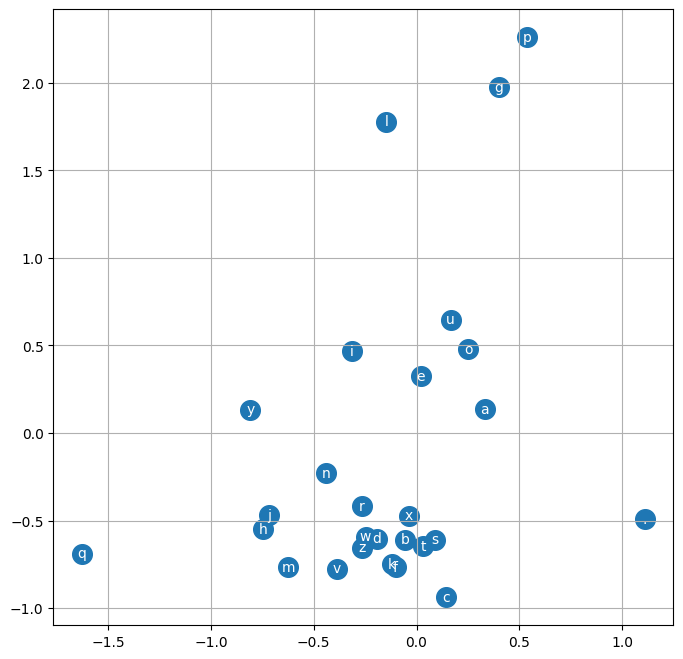

In [133]:
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), index_to_string[i], ha="center", va="center", color='white')
plt.grid('minor')

In [150]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(30):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(index_to_string[i] for i in out))

montalmyah.
seel.
ndheyah.
rethantendraeg.
aderedieliigh.
piopaleigh.
sananaraelynn.
soura.
noshubergiaghiest.
jairetlynn.
nopuofiura.
geder.
yadue.
ehs.
kaysh.
skylanihia.
salynnsti.
zajoure.
ren.
cre.
kivia.
elin.
adid.
kyloe.
ban.
prick.
amueh.
con.
reon.
isa.
